## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
import math
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb
from matplotlib_venn import venn2
import umap

import texthero as hero
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import nltk

from catboost import CatBoost
from catboost import Pool

nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['romanian',
 'greek',
 'german',
 'spanish',
 'italian',
 'swedish',
 'README',
 'nepali',
 'tajik',
 'finnish',
 'danish',
 'hungarian',
 'norwegian',
 'arabic',
 'azerbaijani',
 'dutch',
 'french',
 'portuguese',
 'turkish',
 'slovene',
 'english',
 'indonesian',
 'russian',
 'kazakh']

## Settings

In [2]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [3]:
SEED = 42
N_SPLITS = 4
SHUFFLE = True
EMB_DIM = 100
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.01,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 1000,
    'verbose_eval': 200,
}


CAT_PARAMS = {
    # 損失関数に RMSE を使う
    'loss_function': 'RMSE',
    'num_boost_round': 10000,
    "learning_rate": 0.04,
    'use_best_model': True,
    'early_stopping_rounds': 1000,
}

SAVE_TEST_SUB_PATH = "sub24.csv"
SAVE_OOF_SUB_PATH = "oof24.csv"

## Utility

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [5]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## Feature Engineering

In [6]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
len_train = len(train)

saturation_train = pd.read_csv(DATA_PATH + 'saturation_train.csv')
train = train.merge(saturation_train, how='left', on='object_id')
saturation_test = pd.read_csv(DATA_PATH + 'saturation_test.csv')
test = test.merge(saturation_test, how='left', on='object_id')

# value50_train = pd.read_csv(DATA_PATH + 'value50_train.csv')
# train = train.merge(value50_train, how='left', on='object_id')
# value50_test = pd.read_csv(DATA_PATH + 'value50_test.csv')
# test = test.merge(value50_test, how='left', on='object_id')

y = np.log1p(train["likes"])
whole_df = pd.concat([train, test]).reset_index(drop=True)
train

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,saturation
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,239.0
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,110.0
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,NaN
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,229.0
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,transfer,1994-01-01T00:00:00,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,61.0
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",purchase,1881-01-01T00:00:00,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,183.0
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,transfer,1887-01-01T00:00:00,NaN,1778,1778.0,18,1778.0,1778.0,0,95.0
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",purchase,1881-01-01T00:00:00,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,139.0


In [7]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'saturation',
#         'value50'
    ]
    output_df = input_df[use_columns].copy()
#     output_df['date_range'] = input_df['dating_year_late'] - input_df['dating_year_early']

    return output_df

In [8]:
def create_size_feature(input_df):
    
    output_df = pd.DataFrame()
    for i, axis in  enumerate(['h', 'w', 't', 'd']):
        if i <= 3:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        else :
            column_name = 'weight'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(kg)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].str.replace('/', '.')
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        output_df[column_name] = size_info[column_name] # trainにくっつける
#     output_df['area'] = output_df['size_t'] * output_df['size_w']

    return output_df

In [9]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
#         'description'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength_')

In [10]:
def create_person_feature(input_df):
    
    hist = pd.read_csv(DATA_PATH + 'historical_person.csv')
    hist = hist.groupby('object_id').count().reset_index()
    hist = hist.rename(columns={'name':'hist_person'})
    
    out_df = pd.merge(input_df, hist, on='object_id', how='left')
            
    return out_df['hist_person']

In [11]:
def create_isnan_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'description',
#         'acquisition_credit_line', 
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].isnull().astype('int')

    return out_df.add_prefix('isnan_')

In [12]:
def create_count_encoding_feature(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いので削除
    use_columns = ['art_series_id', 
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late']

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = input_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

In [13]:
def create_language_feature(input_df):
    use_columns = ['title', 'description', 'more_title',
        'long_title', 'principal_maker', 'principal_or_first_maker',
        'copyright_holder',
       'acquisition_credit_line']
    model = load_model(DATA_PATH + "lid.176.bin")
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].fillna("").map(
            lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('lang_')

#     out_df = pd.DataFrame()
#     for column in use_columns:
#         lang_series = input_df[column].fillna("").map(
#             lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        
#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = lang_series.value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(lang_series, categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

In [14]:
def create_label_encoding(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いが，削除するとCV下がったので残す
    use_columns = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('LE_')

In [15]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late'
    ]
    out_df = pd.DataFrame()
    for i, column in enumerate(use_columns):

        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = input_df[column].value_counts()
        vc = vc[vc > 20]

        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)

        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = [str(i) for i in range(len(out_i.columns))]
#         out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [16]:
def create_maker_info(input_df):
    
    tgt = 'principal_maker'
    col = 'dating_sorting_date'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = EMB_DIM
    pca = PCA(random_state=SEED,n_components=n_)
#     pca = umap.UMAP(random_state=42, n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:8] +  '_' + col[-4:]+ '_' + val + '_reduce_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [17]:
def create_maker_famouse_info(input_df):
    
    maker = pd.read_csv(DATA_PATH + 'maker.csv')
    maker['famouse_point'] = maker.iloc[:, 1:].count(axis=1)
    maker['principal_maker'] = maker['name']
    
    out_df = pd.merge(input_df, maker, on='principal_maker', how='left')
            
    return out_df['famouse_point']

In [18]:
def create_title_info(input_df):
    
    tgt = 'title'
    col = 'principal_maker'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = EMB_DIM
#     pca = umap.UMAP(random_state=42, n_components=n_)
    pca = PCA(random_state=SEED,n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt +  '_' + col[-4:]+ '_' + val + '_reduce_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [19]:
def create_title_tfidf_feature(input_df):
    docs = input_df['title'].values
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100000)),
        ('svd', TruncatedSVD(n_components=50)),
    ])

    z = pipeline.fit_transform(docs)
    col = ['title_tfidf'+str(i) for i in range(z.shape[1])]
    output_df = pd.DataFrame(z, columns=col)
    
    return output_df

In [20]:
def create_saturation_emb_info(input_df):
    
    saturation_emb = pd.read_csv(DATA_PATH + 'saturation_emb.csv')

    n_ = EMB_DIM
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(saturation_emb.iloc[:, :-1].values) 
    cols = ['saturation_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, columns=cols)
    plat_pca_df['object_id'] = saturation_emb['object_id']
    out_df = pd.merge(input_df, plat_pca_df, on='object_id', how='left')[cols]
            
    return out_df

In [21]:
def create_bert_description_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_description_info.csv')

    n_ = EMB_DIM
    reducer = PCA(random_state=SEED, n_components=n_)
#     reducer = umap.UMAP(random_state=42, n_components=n_)
    reduced = reducer.fit_transform(bert_df.iloc[:, 1:].values)
    
    cols = ['bert_description_reduce_'+str(i) for i in range(n_)]
    reduced_df = pd.DataFrame(reduced,  columns=cols)
            
    return reduced_df

In [22]:
def create_bert_more_title_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_more_title_info.csv')

    n_ = EMB_DIM
#     reducer = PCA(n_components=n_)
    reducer = PCA(random_state=SEED, n_components=n_)
#     reducer = umap.UMAP(random_state=42, n_components=n_)
    reduced = reducer.fit_transform(bert_df.iloc[:, 1:].values)
    
    cols = ['bert_m_title_reduce_'+str(i) for i in range(n_)]
    reduced_df = pd.DataFrame(reduced,  columns=cols)
            
    return reduced_df

In [23]:
def create_bert_long_title_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_long_title_info.csv')

    n_ = EMB_DIM
    reducer = PCA(random_state=SEED, n_components=n_)
#     reducer = umap.UMAP(random_state=42, n_components=n_)
    reduced = reducer.fit_transform(bert_df.iloc[:, 1:].values)
    
    cols = ['bert_l_title_reduce_'+str(i) for i in range(n_)]
    reduced_df = pd.DataFrame(reduced,  columns=cols)
            
    return reduced_df

In [24]:
def create_word2vec_info(input_df):
    
    with open(DATA_PATH + 'word2vec.pickle', mode='rb') as fp:
        word2vec_info = pickle.load(fp)
    output_df = pd.DataFrame()
    for i in range(len(word2vec_info)):
        tmp_df = pd.merge(input_df, word2vec_info[i], on='object_id', how='left')
        output_df[word2vec_info[i].columns] = tmp_df[word2vec_info[i].columns]
            
    return output_df 

In [25]:
def create_material_info(input_df):
    
    material_df = pd.read_csv(DATA_PATH + 'material_info.csv')
    out_df = pd.merge(input_df, material_df, on='object_id', how='left')
            
    return out_df[material_df.columns].drop('object_id', axis=1)

In [26]:
def create_technique_info(input_df):
    
    technique_df = pd.read_csv(DATA_PATH + 'technique_info.csv')
    out_df = pd.merge(input_df, technique_df, on='object_id', how='left')
            
    return out_df[technique_df.columns].drop('object_id', axis=1)

In [27]:
def create_place_region_info(input_df):
    
    place_df = pd.read_csv(DATA_PATH + 'place_info.csv')
    out_df = pd.merge(input_df, place_df, on='object_id', how='left')
            
    return out_df[place_df.columns].drop('object_id', axis=1)

In [28]:
def create_place_info(input_df):
    
    production_country = pd.read_csv(DATA_PATH + 'production_place_country.csv')   
    out_df = pd.merge(input_df, production_country, on='object_id', how='left')
            
    return out_df[production_country.columns].drop('object_id', axis=1)

In [29]:
def create_person_info(input_df):
    
    person = pd.read_csv(DATA_PATH + 'person_one_hot.csv')   
    out_df = pd.merge(input_df, person, on='object_id', how='left')
            
    return out_df[person.columns].drop('object_id', axis=1)

In [30]:
def create_color_emb_info(input_df):
    
    embedding_df = pd.read_csv(DATA_PATH + 'color_emb200_max.csv')   
    out_df = pd.merge(input_df, embedding_df, on='object_id', how='left')
            
    return out_df[embedding_df.columns].drop('object_id', axis=1)

In [31]:
def create_palette_feature(input_df):
    output_df = input_df.copy()
    palette = pd.read_csv(DATA_PATH + 'palette.csv')

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_palette, on="object_id", how="left")

    # 平均のrgbを取得
#     mean_palette = palette.copy()
#     mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
#     mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
#     mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
#     mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
#         columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
#     output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")

    use_columns = ["max_palette_r","max_palette_g","max_palette_b"]
    return output_df[use_columns]

In [32]:
def text_normalization(text):

    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

In [33]:
def create_tfidf_feature(input_df):

    columns = ['description', 'title', 'long_title', 'more_title']
    
    output_df = pd.DataFrame()
    for column in columns:
        docs = text_normalization(input_df[column])
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])

        z = pipeline.fit_transform(docs)
        z_df = pd.DataFrame(z)
        z_df = z_df.add_prefix(f'{column}_tfidf_')
        output_df = pd.concat([output_df, z_df], axis=1)


    return output_df

In [34]:
def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_isnan_feature,
        create_person_feature,
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_label_encoding,
        create_title_tfidf_feature,
        create_size_feature,
        create_language_feature,
        create_maker_info,
#         create_saturation_emb_info,
        create_title_info,
        create_material_info,
        create_place_info,
        create_tfidf_feature,
        create_bert_description_info,
        create_bert_more_title_info,
        create_bert_long_title_info,
        create_maker_famouse_info,
#         create_place_region_info,
        create_palette_feature,
        create_technique_info,
        create_word2vec_info,
        create_color_emb_info,
#         create_person_info
#         create_one_hot_encoding
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [35]:
whole_feat_df = to_feature(whole_df)

 23%|██▎       | 5/22 [00:00<00:00, 35.52it/s]

create_isnan_feature  0.004[s]
create_person_feature  0.019[s]
create_numeric_feature  0.001[s]
create_string_length_feature  0.023[s]
create_count_encoding_feature  0.086[s]
create_label_encoding  0.094[s]
create_title_tfidf_feature  0.534[s]
create_size_feature  1.005[s]


 41%|████      | 9/22 [00:03<00:06,  1.94it/s]

create_language_feature  2.086[s]
create_maker_info  0.222[s]


 59%|█████▉    | 13/22 [00:08<00:06,  1.41it/s]

create_title_info  4.064[s]
create_material_info  0.029[s]
create_place_info  0.031[s]
create_tfidf_feature  8.111[s]


 68%|██████▊   | 15/22 [00:19<00:14,  2.10s/it]

create_bert_description_info  2.930[s]


 73%|███████▎  | 16/22 [00:22<00:13,  2.31s/it]

create_bert_more_title_info  3.268[s]


 77%|███████▋  | 17/22 [00:26<00:12,  2.50s/it]

create_bert_long_title_info  3.196[s]
create_maker_famouse_info  0.016[s]


 86%|████████▋ | 19/22 [00:26<00:05,  1.68s/it]

create_palette_feature  0.327[s]
create_technique_info  0.022[s]


 95%|█████████▌| 21/22 [00:26<00:01,  1.19s/it]

create_word2vec_info  0.292[s]


100%|██████████| 22/22 [00:27<00:00,  1.23s/it]

create_color_emb_info  0.145[s]


In [36]:
test_feat_df = whole_feat_df.iloc[len_train:].reset_index(drop=True)
train_feat_df = whole_feat_df.iloc[:len_train].reset_index(drop=True)
X = train_feat_df
X

,isnan_description,hist_person,dating_period,dating_year_early,dating_year_late,saturation,StringLength_title,StringLength_long_title,StringLength_sub_title,StringLength_more_title,...,color_embedding_54,color_embedding_55,color_embedding_56,color_embedding_57,color_embedding_58,color_embedding_59,color_embedding_60,color_embedding_61,color_embedding_62,color_embedding_63
0,1,NaN,17,1660.0,1685.0,239.0,21,48,39.0,21.0,...,5.452029,-0.357286,-1.540021,-14.248941,-0.206386,2.107671,-1.820955,-11.460013,-5.706292,-1.168918
1,1,NaN,19,1900.0,1930.0,110.0,15,64,17.0,15.0,...,2.076548,-0.795957,0.045016,-9.236140,0.852483,0.464779,-0.772332,-8.238482,-3.618538,0.159386
2,0,NaN,19,1860.0,1880.0,NaN,21,52,15.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,19,1850.0,1879.0,229.0,16,53,25.0,16.0,...,4.522314,1.337780,-1.272340,-0.462011,-0.017821,2.083474,-0.726437,1.324443,-0.477537,-0.760832
4,0,NaN,19,1825.0,1874.0,255.0,27,51,27.0,27.0,...,5.748004,-0.229146,-1.611689,-13.541443,-0.099227,2.286742,-1.720518,-10.675272,-5.428721,-1.116961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,1,1.0,19,1900.0,1920.0,61.0,37,65,16.0,48.0,...,-5.406126,-0.274877,-0.874854,3.536402,-3.616648,-1.849250,0.437474,2.512921,1.445901,-1.593118
12022,0,NaN,18,1701.0,1714.0,183.0,60,89,17.0,424.0,...,-5.997911,0.002593,-1.977944,3.795091,-6.036482,-1.908516,0.267977,3.215141,1.601934,-2.582055
12023,0,NaN,18,1778.0,1778.0,95.0,54,85,17.0,141.0,...,-0.959141,0.125027,0.038235,2.466658,-0.315905,-0.375382,0.341913,2.344870,1.083443,-0.026896
12024,0,6.0,17,1689.0,1690.0,139.0,29,72,17.0,145.0,...,-1.257305,0.416132,-0.951481,2.781953,-1.785430,-0.326708,0.064853,2.826954,1.127291,-1.137836


## Train / Test

In [37]:
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

In [38]:

kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)

y_test = np.zeros([N_SPLITS, len(test_feat_df)])
oof_pred = np.zeros_like(y, dtype=np.float)
models = []

# kfoldで分割
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # データセットを生成する
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_valid, y_valid)
    
    train_pool = Pool(X_train, label=y_train)
    eval_pool = Pool(X_valid, label=y_valid)

    # 学習
#     evals_results = {}
#     model = lgb.train(LGBM_PARAMS,
#                         lgb_train,
#                         valid_sets=[lgb_eval, lgb_train],
#                         evals_result=evals_results,
#                         **LGBM_FIT_PARAMS)
    
    model = CatBoost(CAT_PARAMS)
    model.fit(train_pool, eval_set=[train_pool, eval_pool], verbose_eval=200, early_stopping_rounds=1000)

    predict_train = model.predict(X_train)
    predict_eval = model.predict(X_valid)
    
    oof_pred[valid_index] = predict_eval
    models.append(model)
    
    rmse_train = calc_loss(y_train, predict_train)
    rmse_eval = calc_loss(y_valid, predict_eval)
    print(f'epoch: {i} RMSE_train: {rmse_train}, RMSE_eval: {rmse_eval}')
    
    y_test[i] = model.predict(test_feat_df)
    
oof_score = calc_loss(y, oof_pred)
print(f'RMSE_oof: {oof_score}')

0:	learn: 1.7409421	test: 1.7409421	test1: 1.7337096	best: 1.7337096 (0)	total: 88ms	remaining: 14m 39s
200:	learn: 0.9972418	test: 0.9972418	test1: 1.0943274	best: 1.0943274 (200)	total: 7.35s	remaining: 5m 58s
400:	learn: 0.8675530	test: 0.8675530	test1: 1.0621451	best: 1.0621451 (400)	total: 14.5s	remaining: 5m 47s
600:	learn: 0.7660518	test: 0.7660518	test1: 1.0476094	best: 1.0474298 (595)	total: 21.7s	remaining: 5m 40s
800:	learn: 0.6834412	test: 0.6834412	test1: 1.0379831	best: 1.0379684 (797)	total: 29s	remaining: 5m 32s
1000:	learn: 0.6149657	test: 0.6149657	test1: 1.0321905	best: 1.0321905 (1000)	total: 36.2s	remaining: 5m 25s
1200:	learn: 0.5570078	test: 0.5570078	test1: 1.0273358	best: 1.0273269 (1198)	total: 43.4s	remaining: 5m 17s
1400:	learn: 0.5059616	test: 0.5059616	test1: 1.0244181	best: 1.0242347 (1392)	total: 50.6s	remaining: 5m 10s
1600:	learn: 0.4626643	test: 0.4626643	test1: 1.0227131	best: 1.0226639 (1578)	total: 57.9s	remaining: 5m 3s
1800:	learn: 0.4252479	test

In [39]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [40]:
oof_pred_ex = np.expm1(oof_pred)
oof_df = pd.DataFrame(oof_pred_ex)
oof_df.to_csv(SAVE_OOF_SUB_PATH,index=False)

In [41]:
1.0033512780179208

1.0033512780179208

## Confirm

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

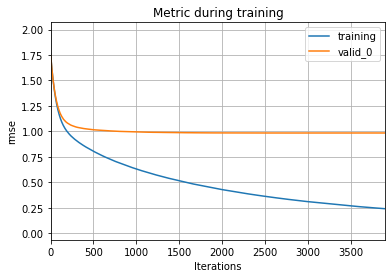

In [41]:
# lgb.plot_metric(evals_results, metric='rmse', )

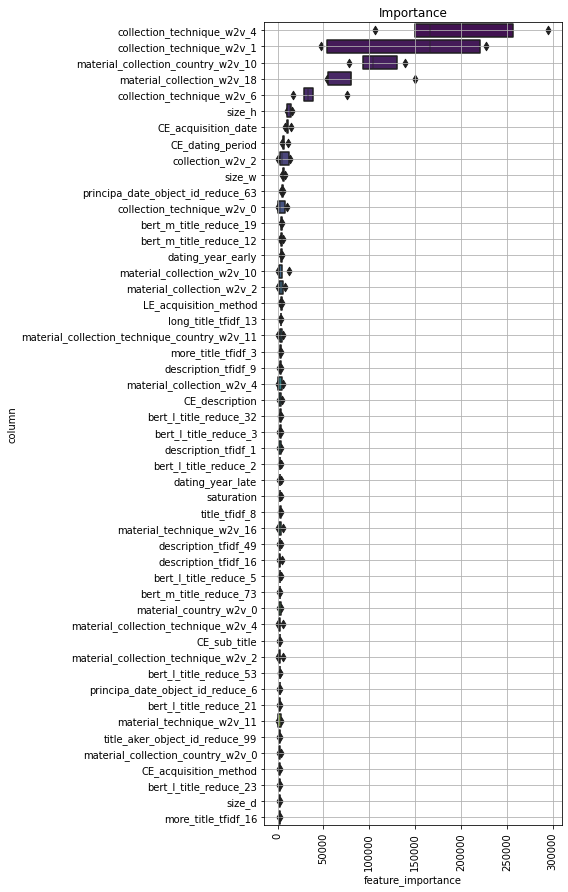

In [42]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

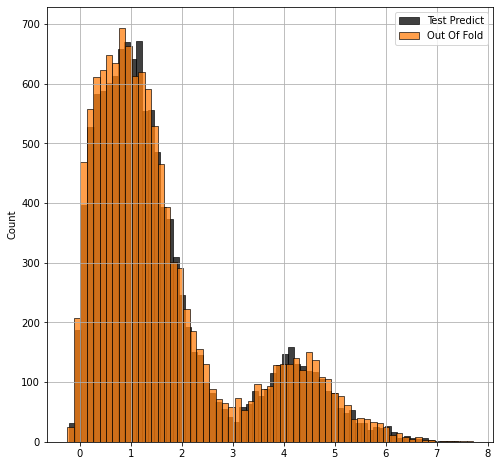

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(y_test_sub), label='Test Predict', ax=ax, color='black')
sns.histplot(oof_pred, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [44]:
tgt_column = [s for s in list(train_feat_df.columns) if 'w2v' in s]

In [45]:
def plot_intersection(left, right, column, set_labels, ax=None):
    left_set = set(left[column].dropna(how='all'))
    right_set = set(right[column].dropna(how='all'))
    venn2(subsets=(left_set, right_set), set_labels=set_labels, ax=ax)
    return ax

def plot_right_left_inersection(train_df, test_df, columns='__all__'):
    """2つのデータフレームのカラムの共通集合を可視化"""
    if columns == '__all__':
        columns = set(train_df.columns) & set(test_df.columns)

    columns = list(columns)
    nfigs = len(columns)
    ncols = 6
    nrows = - (- nfigs // ncols)
    fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
    axes = np.ravel(axes)
    for c, ax in zip(columns, axes):
        plot_intersection(train_df, test_df, column=c, set_labels=('Train', 'Test'), ax=ax)
        ax.set_title(c)
    return fig, ax

In [46]:
# fig_features = tgt_column

# train_fig = train_feat_df[fig_features]
# test_fig = test_feat_df[fig_features]
# fig, _ = plot_right_left_inersection(train_fig, test_fig)
# fig.tight_layout()